In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
ticker ="INFY.NS"  
start_date = '2022-01-01'
end_date = '2024-12-31'

In [3]:
# Fetch Infosys data using yfinance
infosys_data = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [4]:
# Display the fetched data
print(infosys_data)


Price             Close         High          Low         Open   Volume
Ticker          INFY.NS      INFY.NS      INFY.NS      INFY.NS  INFY.NS
Date                                                                   
2022-01-03  1779.762329  1794.387137  1769.731319  1769.731319  3329616
2022-01-04  1780.418823  1787.449938  1760.591058  1779.762517  3921999
2022-01-05  1729.325928  1783.934246  1724.966614  1781.215526  6995719
2022-01-06  1704.154541  1713.716810  1687.467318  1713.716810  6449205
2022-01-07  1700.873413  1721.216724  1693.842299  1701.951426  4834389
...                 ...          ...          ...          ...      ...
2024-12-23  1924.300049  1940.000000  1909.000000  1930.050049  2781793
2024-12-24  1909.050049  1942.000000  1840.000000  1927.050049  2360544
2024-12-26  1907.400024  1919.750000  1902.300049  1909.050049  3623321
2024-12-27  1916.750000  1924.150024  1903.900024  1909.400024  3937500
2024-12-30  1906.000000  1916.000000  1886.500000  1915.699951  

In [5]:
print(infosys_data.head())

Price             Close         High          Low         Open   Volume
Ticker          INFY.NS      INFY.NS      INFY.NS      INFY.NS  INFY.NS
Date                                                                   
2022-01-03  1779.762329  1794.387137  1769.731319  1769.731319  3329616
2022-01-04  1780.418823  1787.449938  1760.591058  1779.762517  3921999
2022-01-05  1729.325928  1783.934246  1724.966614  1781.215526  6995719
2022-01-06  1704.154541  1713.716810  1687.467318  1713.716810  6449205
2022-01-07  1700.873413  1721.216724  1693.842299  1701.951426  4834389


In [6]:
print(infosys_data.tail())

Price             Close         High          Low         Open   Volume
Ticker          INFY.NS      INFY.NS      INFY.NS      INFY.NS  INFY.NS
Date                                                                   
2024-12-23  1924.300049  1940.000000  1909.000000  1930.050049  2781793
2024-12-24  1909.050049  1942.000000  1840.000000  1927.050049  2360544
2024-12-26  1907.400024  1919.750000  1902.300049  1909.050049  3623321
2024-12-27  1916.750000  1924.150024  1903.900024  1909.400024  3937500
2024-12-30  1906.000000  1916.000000  1886.500000  1915.699951  7789055


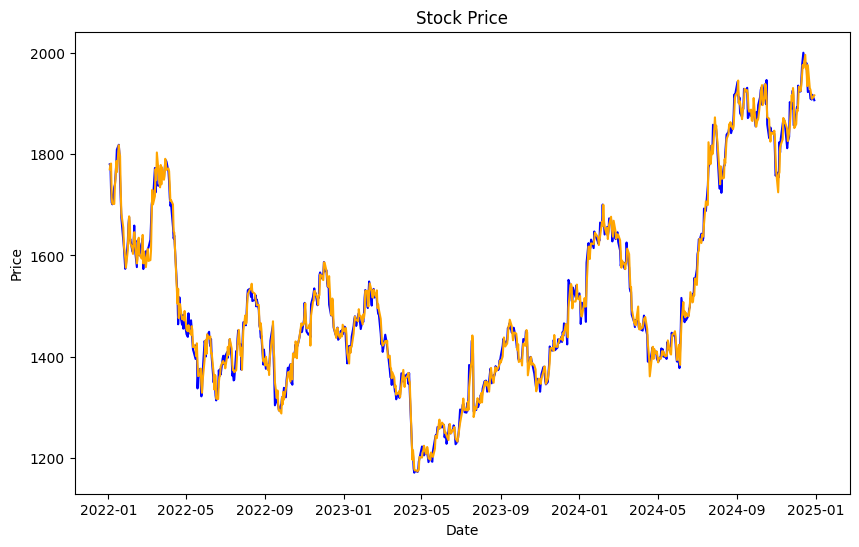

In [7]:
plt.figure(figsize=(10,6))
plt.plot(infosys_data['Close'], label='Close Price', color ='blue')
plt.plot(infosys_data['Open'], label = 'Open Price', color = 'orange')
plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [8]:
#Check Stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(infosys_data['Close'])
print("ADF Statics :",result[0])
print ("p-value :",result[1])
if(result[1]<=0.05):
    print("The data is stationary")
else:
    print("The data is not stationary. Differencing required.")


ADF Statics : -1.3406445052284532
p-value : 0.6103784701851861
The data is not stationary. Differencing required.


In [9]:
#Differencing
infosys_data['Close_differencing']=infosys_data['Close'].diff().dropna()
#Checking data is stationary or not
result= adfuller(infosys_data['Close_differencing'].dropna())
print("ADF Statics :",result[1])
print("p-value :",result[1])
if(result[1]<=0.05):
    print("The data is stationary.")
else:
    print("The data is not stationary. Differencing might be required.")



ADF Statics : 0.0
p-value : 0.0
The data is stationary.


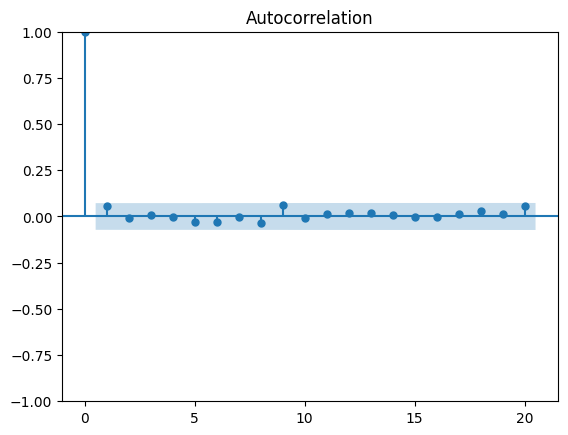

In [10]:
#Autocorrelation and Partial Autocorrelation
plot_acf(infosys_data["Close_differencing"].dropna(),lags=20)
plt.show()



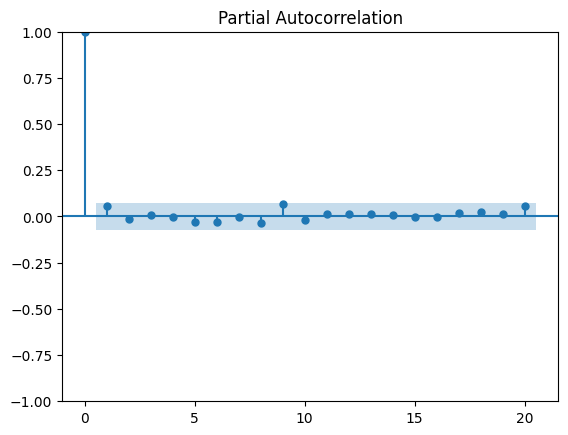

In [11]:
plot_pacf(infosys_data["Close_differencing"].dropna(),lags=20)
plt.show()

In [12]:
#Calculate 30 day Moving Average
infosys_data['30_day_MA'] = infosys_data['Close_differencing'].rolling(window=30).mean()


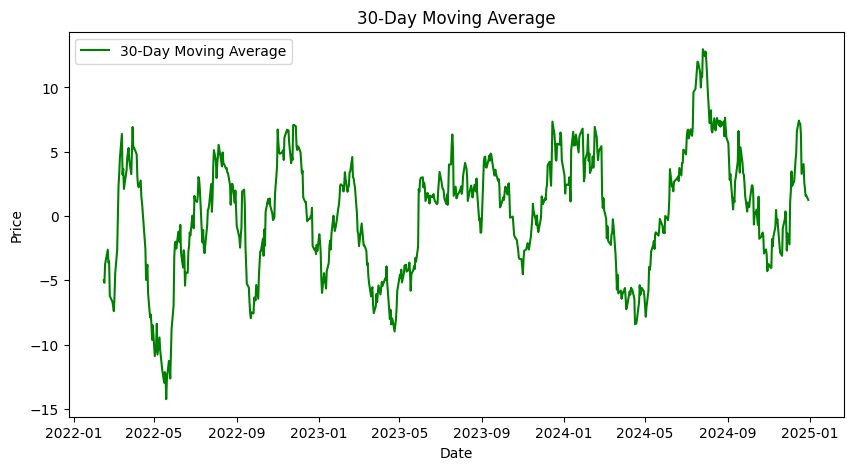

In [13]:
#Plotting the Moving Average
plt.figure(figsize=(10,5))
plt.plot(infosys_data['30_day_MA'],label ='30-Day Moving Average', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('30-Day Moving Average')
plt.legend()
plt.show()


In [14]:
# Calculate Simple Moving Averages (SMA)
infosys_data['SMA_20'] = infosys_data['Close'].rolling(window=20).mean()
infosys_data['SMA_50'] = infosys_data['Close'].rolling(window=50).mean()

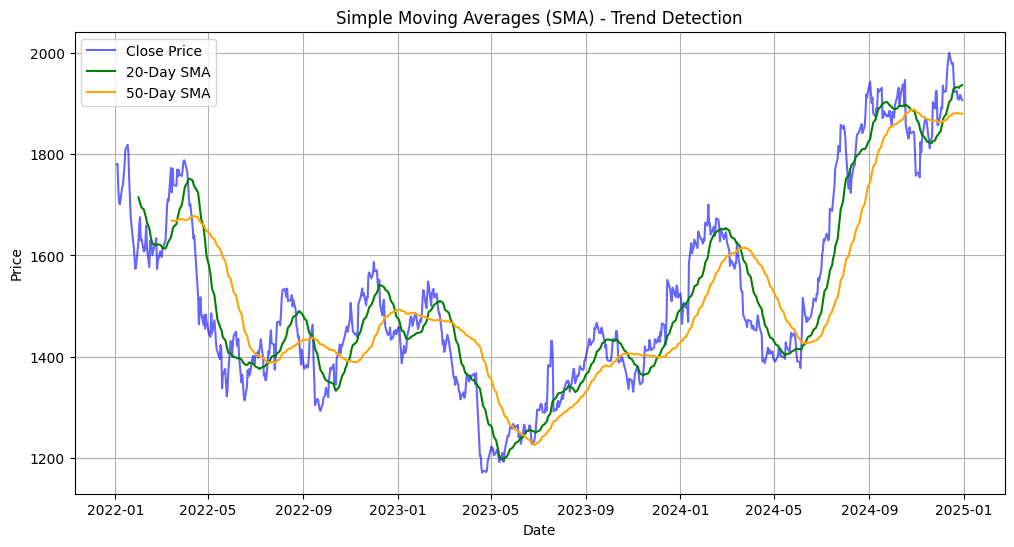

In [15]:
# Plot Moving Averages to detect trends
plt.figure(figsize=(12, 6))
plt.plot(infosys_data['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(infosys_data['SMA_20'], label='20-Day SMA', color='green')
plt.plot(infosys_data['SMA_50'], label='50-Day SMA', color='orange')
plt.title('Simple Moving Averages (SMA) - Trend Detection')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Simple Strategy: Crossover signals
# If SMA_20 crosses above SMA_50, it's a buy signal (uptrend)
# If SMA_20 crosses below SMA_50, it's a sell signal (downtrend)

infosys_data['Signal'] = 0
infosys_data.loc[infosys_data['SMA_20'] > infosys_data['SMA_50'], 'Signal'] = 1  # Buy signal
infosys_data.loc[infosys_data['SMA_20'] < infosys_data['SMA_50'], 'Signal'] = -1  # Sell signal

# Display the last few rows of the dataset
print(infosys_data[['Close', 'SMA_20', 'SMA_50','Signal']].tail(10))


Price             Close       SMA_20       SMA_50 Signal
Ticker          INFY.NS                                 
Date                                                    
2024-12-16  1980.050049  1907.842505  1876.992812      1
2024-12-17  1976.599976  1916.100006  1878.593701      1
2024-12-18  1979.150024  1923.820007  1879.926226      1
2024-12-19  1946.199951  1929.427502  1880.317957      1
2024-12-20  1922.150024  1930.422504  1880.145637      1
2024-12-23  1924.300049  1932.152509  1880.683718      1
2024-12-24  1909.050049  1931.397510  1880.598425      1
2024-12-26  1907.400024  1930.542511  1880.009490      1
2024-12-27  1916.750000  1933.547510  1879.599644      1
2024-12-30  1906.000000  1935.955011  1879.749971      1


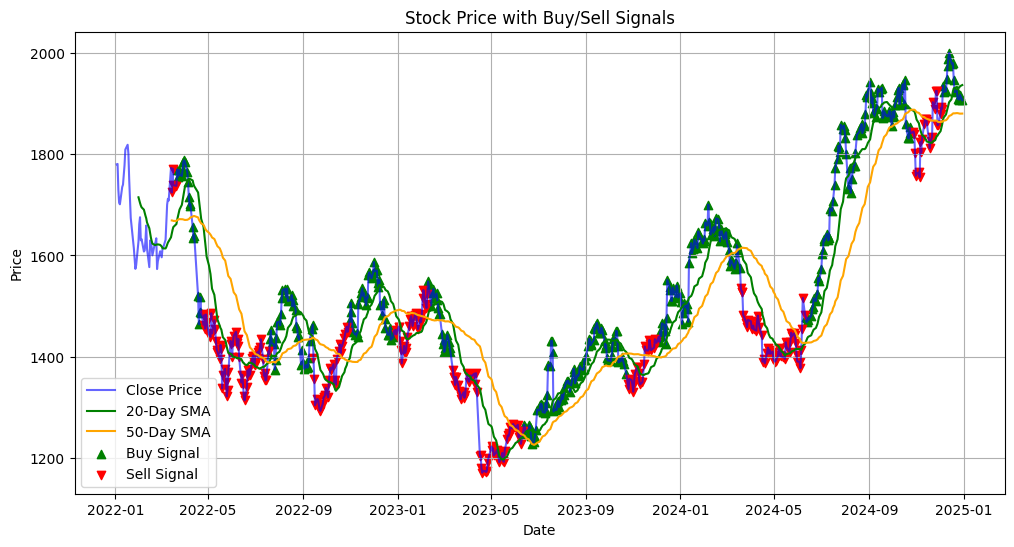

In [17]:
# Visualize signals
plt.figure(figsize=(12, 6))
plt.plot(infosys_data['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(infosys_data['SMA_20'], label='20-Day SMA', color='green')
plt.plot(infosys_data['SMA_50'], label='50-Day SMA', color='orange')

# Mark Buy/Sell Signals
buy_signals = infosys_data[infosys_data['Signal'] == 1]
sell_signals = infosys_data[infosys_data['Signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='red', alpha=1)

plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Trend Analysis
trend = "Uptrend" if infosys_data['Signal'].iloc[-1] == 1 else "Downtrend" if infosys_data['Signal'].iloc[-1] == -1 else "Sideways"
print(f"Current Trend: {trend}")

Current Trend: Uptrend


In [19]:
#Fitting the ARIMA Model
model = ARIMA(infosys_data['Close'], order=(20,1,9))
arima_result = model.fit()
print(arima_result.summary())

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:                INFY.NS   No. Observations:                  738
Model:                ARIMA(20, 1, 9)   Log Likelihood               -3370.606
Date:                Tue, 07 Jan 2025   AIC                           6801.212
Time:                        13:48:00   BIC                           6939.289
Sample:                             0   HQIC                          6854.459
                                - 738                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0486      1.075      0.045      0.964      -2.059       2.156
ar.L2          0.2386      1.101      0.217      0.828      -1.919       2.396
ar.L3         -0.7395      1.206     -0.613      0.5

In [20]:
start_date = pd.to_datetime("2024-11-1")
end_date = pd.to_datetime("2024-12-30")

In [21]:
#Check if the dates are within the range of the index
if start_date not in infosys_data.index or end_date not in infosys_data.index:
    print(f"The start_date or end_date is not found in the infosys_data's index. Availabe dates are:")
    print(infosys_data.index.min(), "to", infosys_data.index.max())
else:
    predicted_data = arima_result.predict(start=start_date, end=end_date,typ="level")
    print(infosys_data['Close'].tail(10))
    print("\n Predicted Data")
    print(predicted_data)

Ticker          INFY.NS
Date                   
2024-12-16  1980.050049
2024-12-17  1976.599976
2024-12-18  1979.150024
2024-12-19  1946.199951
2024-12-20  1922.150024
2024-12-23  1924.300049
2024-12-24  1909.050049
2024-12-26  1907.400024
2024-12-27  1916.750000
2024-12-30  1906.000000

 Predicted Data
Date
2024-11-01    1757.653916
2024-11-04    1761.423192
2024-11-05    1761.916373
2024-11-06    1753.739422
2024-11-07    1823.833920
2024-11-08    1800.607515
2024-11-11    1831.616019
2024-11-12    1863.822482
2024-11-13    1861.441968
2024-11-14    1874.003399
2024-11-18    1862.088605
2024-11-19    1808.538562
2024-11-21    1830.261825
2024-11-22    1834.813418
2024-11-25    1906.832785
2024-11-26    1889.818390
2024-11-27    1925.396478
2024-11-28    1921.551347
2024-11-29    1849.958682
2024-12-02    1851.777236
2024-12-03    1881.890489
2024-12-04    1889.210992
2024-12-05    1898.234257
2024-12-06    1940.359074
2024-12-09    1925.226998
2024-12-10    1930.246910
2024-12-11    

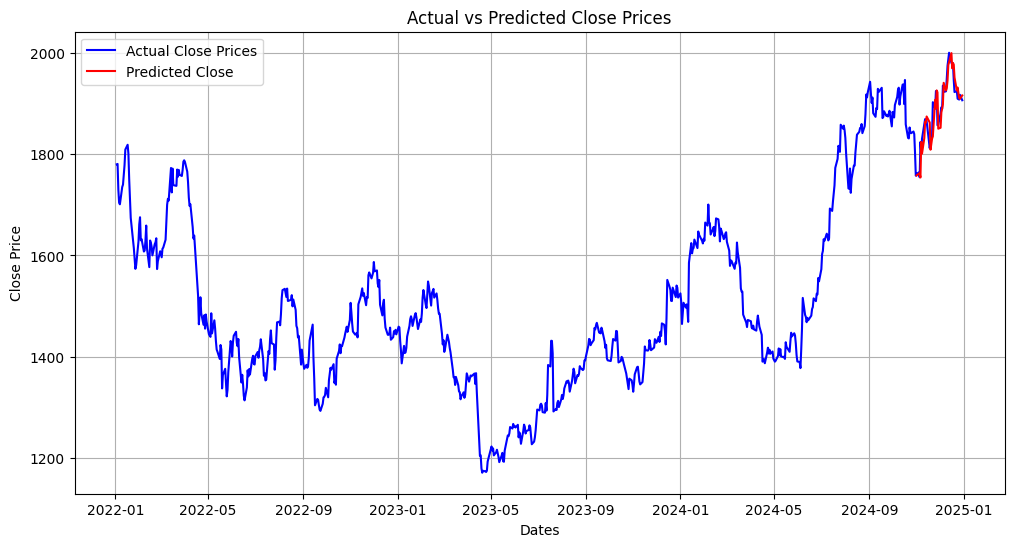

In [22]:
#Plot Actual and Predicted Data
plt.figure(figsize=(12,6))
plt.plot(infosys_data.index,infosys_data['Close'],label ='Actual Close Prices',color='blue')
plt.plot(predicted_data.index,predicted_data, label = 'Predicted Close', color='red')
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Dates")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
#Forecast next 60 days
forecast_steps =60
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=infosys_data.index[-1] +pd.Timedelta(days=1), periods=forecast_steps, freq='B')
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


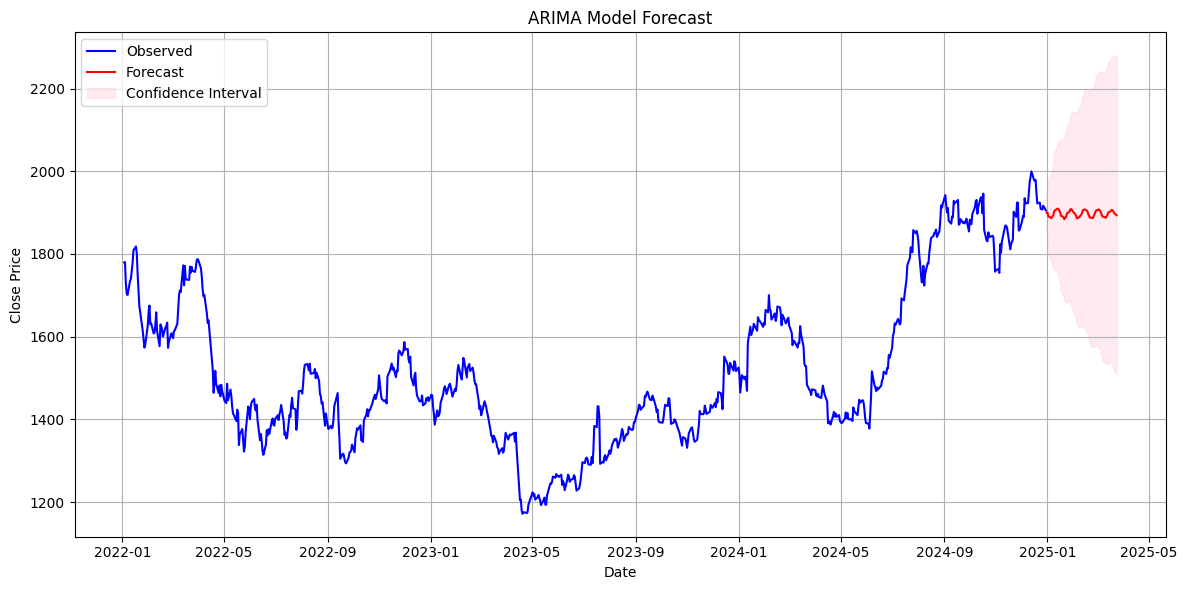

In [24]:
plt.figure(figsize=(12,6))
plt.plot(infosys_data.index, infosys_data['Close'], label ='Observed', color='blue')
plt.plot(forecast_index,forecast_mean, label='Forecast',color='red')
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Ensure that the predictions and actual values are aligned and converted to numpy arrays
actual_values = infosys_data['Close'][-len(predicted_data):].values
predicted_values = predicted_data.values

In [26]:
# Calculate errors
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values) * 100
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

# Normalize errors to percentage
mean_actual = np.mean(actual_values)  
mae_percentage = (mae / mean_actual) * 100
rmse_percentage = (rmse / mean_actual) * 100

# Calculate accuracy
accuracy = 100 - mape

# Print results in percentage
print(f"Mean Absolute Error (MAE): {mae_percentage:.2f}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse_percentage:.2f}%")
print(f"Model Accuracy: {accuracy:.2f}%")

Mean Absolute Error (MAE): 1.01%
Mean Absolute Percentage Error (MAPE): 1.02%
Root Mean Squared Error (RMSE): 1.40%
Model Accuracy: 98.98%
